In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('data/Eluvio_DS_Challenge.csv')

In [ ]:
data.head()

In [ ]:
data.tail()

## Visualization for feature dependence

### Check the number of posts made across the years and as per the day of the week

In [ ]:
def add_time_features(df):
    # Use the "date_created" field to extract features like "day_of_week", "year", "month"
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['time_created'] = pd.to_datetime(df['time_created'], unit='s')
    df['day_of_week'] = df['date_created'].dt.day_name()
    df['day_of_week_num']=df['date_created'].dt.dayofweek
    df['year'] = df['date_created'].dt.year
    df['month'] = df['date_created'].dt.month
    df['day'] = df['date_created'].dt.day
    df['hour'] = df['time_created'].dt.hour + df['time_created'].dt.minute/60 + df['time_created'].dt.second/3600
    return df

In [ ]:
data_with_time = add_time_features(data)
data_with_time.head(5)

### Number of Posts vs Year/Day_of_Week

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
g = sns.countplot(x='year', data=data_with_time, ax=ax[0])
g.set_title('Num of posts vs Year')
g = sns.countplot(x='day_of_week',data=data_with_time,ax=ax[1])
g.set_title('Num of posts vs Day of Week')

### Number of Up Votes vs Year/Day_of_Week

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
set1 = data_with_time.groupby('year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='year',y='avg_upvotes',data=set1, ax=ax[0])
set2 = data_with_time.groupby('day_of_week').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='day_of_week',y='avg_upvotes',data=set2, ax=ax[1])

- In the above figures, we can see that a lot of posts were made after the **year 2012**
- Also, the number of posts made has nothing much to do with the day of the week. So, there is no correlation between the number of posts and the day of week

### Number of Up Votes throughout the day

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
set3 = data_with_time.groupby('hour').count()['up_votes'].reset_index(name='Num_Up_Votes')
sns.scatterplot(x='hour', y='Num_Up_Votes', data=set3, ax=ax[0])

set4 = data_with_time.groupby('hour').mean()['up_votes'].reset_index(name='Average_Up_Votes')
sns.scatterplot(x='hour', y='Average_Up_Votes', data=set4, ax=ax[1])

- This shows that posts made somewhere between 10:00 hour and 20:00 hour get most number of **up_votes** during the day
- This can be a good insight on what time to choose before making a post so that it gets the most number of up_votes

## Conclusion

- Looks like only two of the features really have any meaning in the dataset: **up_votes** and **title**



## Problem Statements

- Taking **title** as an input feature to our machine learning and predicting the amount of **up_votes** that it gets can be a good way to start.

In [ ]:
authors = data.author.unique()
print(f'Unique authors: {authors}')
print(f'Num of unique authors: {len(authors)}')

categories = data.category.unique()
print(f'Unique categories: {categories}')
print(f'Num of unique categories: {len(categories)}')

over_18 = data.over_18.value_counts()
print(f'Over_18: {over_18}')

- This shows that there is no relation between the **author** of the news and the number of **up_votes** that it gets. Same with the **category** of the news. The **up_votes** seem to be only dependent on the **title** of the news.

In [ ]:
data.author.value_counts()

- This shows that some **authors** have a lot of news articles in the dataset compared to other authors who have only 1 or more.
- Can this information be useful in understanding/predicting if a news will get higher number of **up_votes**?

In [ ]:
news_by_david = data.loc[data['author'] == 'davidreiss666']
news_by_david.sort_values(by=['up_votes'], ascending=False)

- It is clear that even though the news is from the same author, we cannot guarantee that it will get similar number of **up_votes**

- Drop all features except "title" and "up_votes"
- Convert "up_votes" into a binomial class: 1: Popular and 0: Not Popular
    - To do so, I'll need to select a threshold (which will be a hyperparameter for the model)

In [2]:
data = pd.read_csv('data/Eluvio_DS_Challenge.csv')
data = data[['title', 'up_votes']]
data.head()

,title,up_votes
0,Scores killed in Pakistan clashes,3
1,Japan resumes refuelling mission,2
2,US presses Egypt on Gaza border,3
3,Jump-start economy: Give health care to all,1
4,Council of Europe bashes EU&UN terror blacklist,4


### Let's study more about how up_votes is distributed in terms of scores
- Will help to find a threshold that divides the dataset into two equal class partitions

In [3]:
data['up_votes'].describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [4]:
# Convert up_votes into a binary class:
votes_threshold = 10
data.loc[data['up_votes'] < votes_threshold, 'up_votes'] = 0
data.loc[data['up_votes'] >= votes_threshold, 'up_votes'] = 1
data.up_votes.value_counts()

0    339079
1    170157
Name: up_votes, dtype: int64

In [5]:
max_count = max(data.up_votes.value_counts())
print(max_count)
weights = [max_count/count for count in data.up_votes.value_counts()]
print(weights)

339079
[1.0, 1.9927419970967988]


- When selecting **"10"** as a threshold for assigning an article as popular, we can see that the dataset can be divided into two groups where almost 2/3rd of the samples fall in the **Not Popular** category
- One way to deal with imbalanced data is to use **class_weights** for the loss function

# Understanding Words Distribution

In [6]:
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud

lemma = WordNetLemmatizer() 
stopwords_en = stopwords.words('english')

def text_process(text):
    # Clean the text
    #text = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"U-turn", "Uturn", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = re.sub(r"@\S+", "", text)

    word=nltk.word_tokenize(text.lower())
    new_word=[w for w in word if w not in stopwords_en and w.isalpha()]
    new_word=[lemma.lemmatize(w, "v") for w in new_word]
    #new_word=[stemmer.stem(w) for w in new_word]
    return new_word

def word_freq(s):
    txt = s.str.lower().str.cat(sep=' ')  
    words = text_process(txt)
    words_dist = nltk.FreqDist(w for w in words) 
    return words_dist

def plot_cloud(words_dist,size):
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black').generate_from_frequencies(words_dist)
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
text = data['title']

In [8]:
print('Original Text:')
print(text[192])
print('Cleaned Text:')
print(text_process(text[192]))

Original Text:
Go and see this exhibition if you are from London!
Cleaned Text:
['go', 'see', 'exhibition', 'london']


In [10]:
words_dist=word_freq(data['title'])

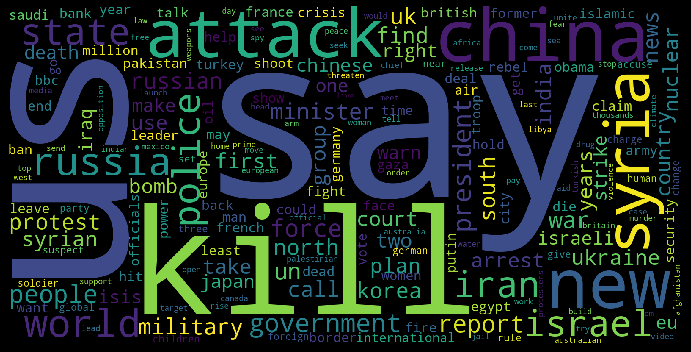

In [11]:
plot_cloud(words_dist,size = (15,5))

# Converting text into feature vector

- To work with text data, we will first need to convert it into feature vectors so that they can be provided as an input to the ML model

### Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors:

- The data that we are working on is in the dataframe as follows:
- So, the column title (containing the text) will need to be converted into numerical features

In [ ]:
data.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['title'].values, data['up_votes'].values, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
print(X_train.shape)

### Tokenizing text for feature vectors

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

In [ ]:
X_train_counts.shape

- This means there are 407,388 training samples with each sample having feature vector of size **80,174** stored in a sparse form
    - By sparse, each title contains a lot of zeros in the feature vector. So, the counts are stored in sparsely to save memory

In [ ]:
X_train_counts[1].data

### From occurrences to frequencies

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
X_train_tfidf[1].data

### Training a Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
predicted = clf.predict(X_test_tfidf)
np.unique(predicted)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print(accuracy_score(y_test, predicted))

In [ ]:
print(confusion_matrix(y_test, predicted))

In [ ]:
from sklearn.linear_model import LogisticRegression 

In [ ]:
log_reg = LogisticRegression(class_weight=weights).fit(X_train_tfidf, y_train)

In [ ]:
predicted = log_reg.predict(X_test_tfidf)
np.unique(predicted)
print(accuracy_score(y_test, predicted))
print(confusion_matrix(y_test, predicted))

In [ ]:
print(classification_report(y_test, predicted))